In [1]:
!pip install pandas numpy pgmpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 28.4 MB/s eta 0:00:00


In [2]:
!pip install pgmpy==0.1.20

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.1 MB/s eta 0:00:0000:01
  Attempting uninstall: pgmpy
    Found existing installation: pgmpy 1.0.0
    Uninstalling pgmpy-1.0.0:
      Successfully uninstalled pgmpy-1.0.0


In [3]:
import pgmpy
print(pgmpy.__version__)

0.1.20


In [4]:
!pip install scikit-learn pandas numpy

In [5]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv('/kaggle/input/credit-risk/UCI_Credit_Card.csv')

In [7]:
for col in ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
            'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
            'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']:
    data[col] = pd.qcut(data[col], q=4, labels=False, duplicates='drop')

In [8]:
for col in ['SEX', 'EDUCATION', 'MARRIAGE', 'default.payment.next.month']:
    data[col] = data[col].astype(int)

In [9]:
scoring_method = BicScore(data)
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=scoring_method)
model = BayesianNetwork(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [10]:
model.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)

In [11]:
inference = VariableElimination(model)

In [12]:
#Probability that a customer pays the payment by default, given evidence
def get_posterior_default(row):
    evidence = {k: row[k] for k in ['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1'] if pd.notna(row[k])}
    try:
        result = inference.query(variables=['default.payment.next.month'], evidence=evidence)
        return result.values[1]
    except:
        return np.nan

#Probability that PAY_0= 2(customer is two months late), given evidence
def get_marginal_pay0(row, state=2):
    evidence = {k: row[k] for k in ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'default.payment.next.month'] if pd.notna(row[k])}
    try:
        result = inference.query(variables=['PAY_0'], evidence=evidence)
        return result.values[state]
    except:
        return np.nan

#Sum the probability of late payment 
def get_late_payment_prob(row):
    evidence = {k: row[k] for k in ['LIMIT_BAL', 'AGE'] if pd.notna(row[k])}
    try:
        result = inference.query(variables=['PAY_0'], evidence=evidence)
        return sum(result.values[1:])  
    except:
        return np.nan


In [13]:
data['P_default'] = data.apply(get_posterior_default, axis=1)
data['P_PAY_0_2'] = data.apply(get_marginal_pay0, axis=1)
data['P_late_payment'] = data.apply(get_late_payment_prob, axis=1)

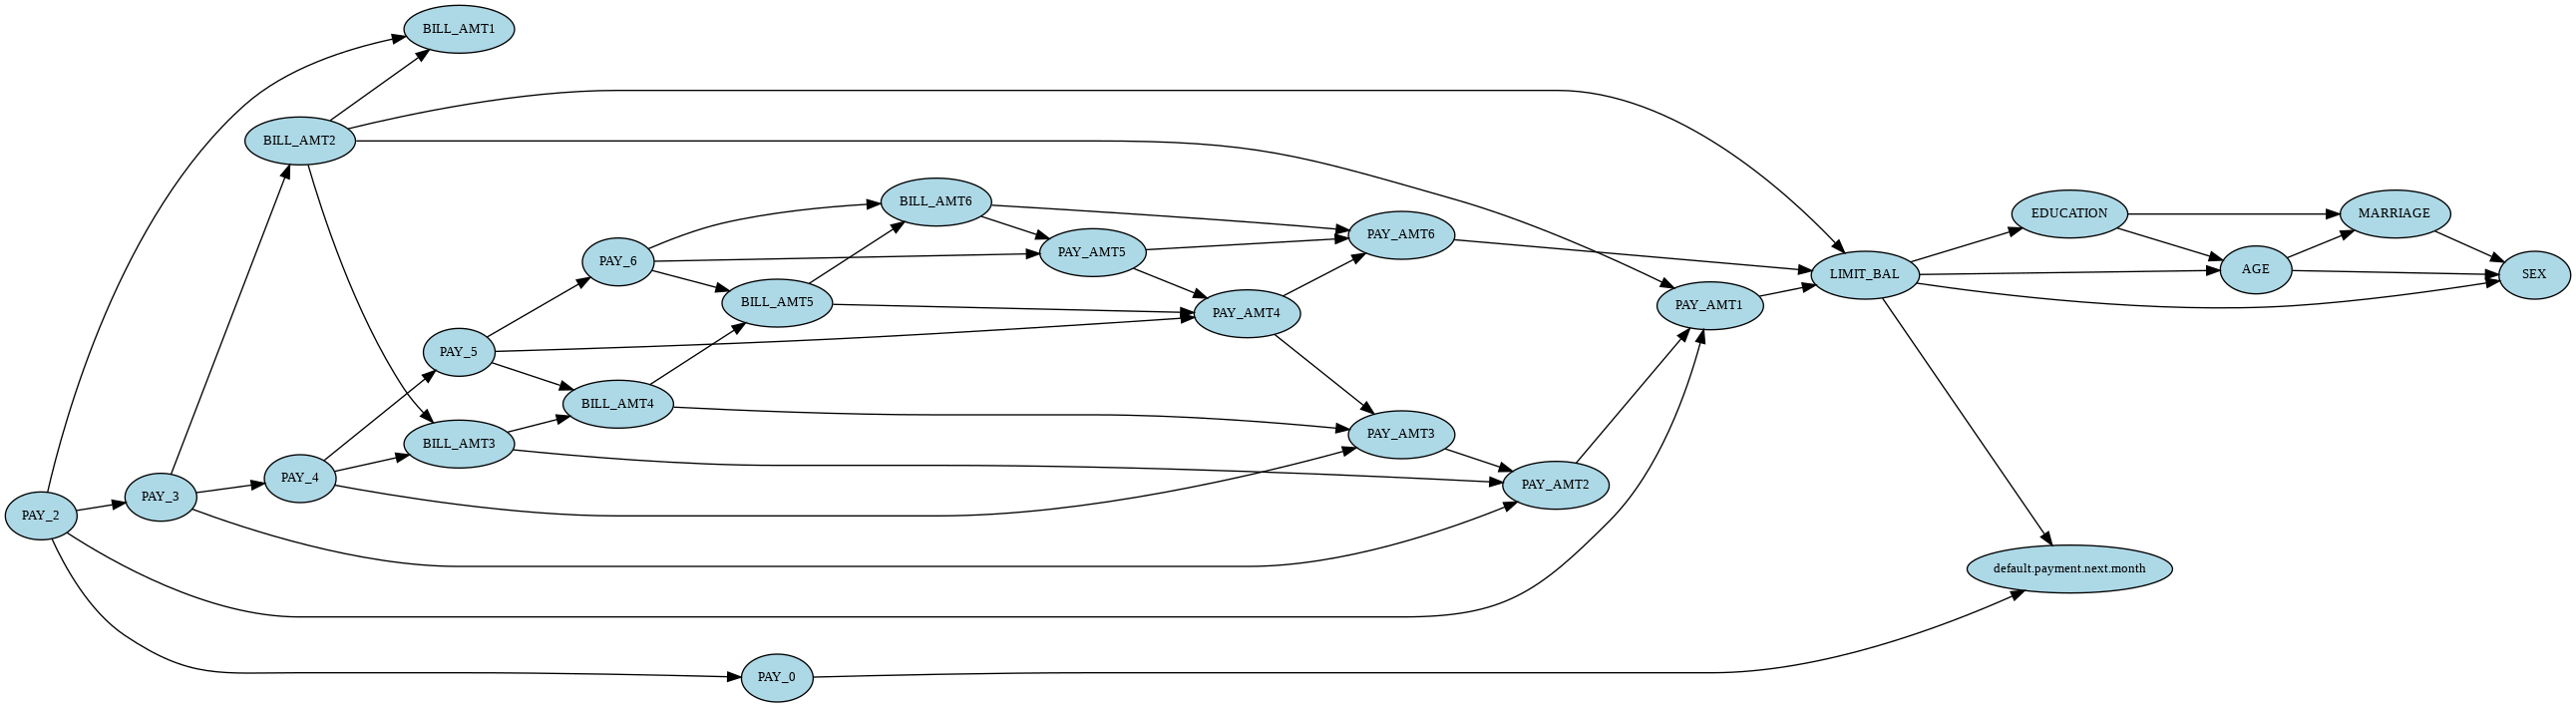

In [15]:
import pydot
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display
import networkx as nx


G = nx.DiGraph()
G.add_edges_from(model.edges())


pydot_graph = to_pydot(G)
pydot_graph.set_rankdir("LR")  


for node in pydot_graph.get_nodes():
    node.set_style("filled")
    node.set_fillcolor("lightblue")
    node.set_fontcolor("black")
    node.set_fontsize("10")
    node.set_shape("ellipse")   


pydot_graph.write_png("bayesian_network.png")
display(Image("bayesian_network.png"))


In [16]:
print("\nConditional Probability Distributions (CPDs):")
for cpd in model.get_cpds():
    print(cpd)



Conditional Probability Distributions (CPDs):
+--------------+---------------------+-----+----------------------+
| BILL_AMT2    | BILL_AMT2(0)        | ... | BILL_AMT2(3)         |
+--------------+---------------------+-----+----------------------+
| PAY_AMT1     | PAY_AMT1(0)         | ... | PAY_AMT1(3)          |
+--------------+---------------------+-----+----------------------+
| PAY_AMT6     | PAY_AMT6(0)         | ... | PAY_AMT6(3)          |
+--------------+---------------------+-----+----------------------+
| LIMIT_BAL(0) | 0.19462549375069776 | ... | 0.000364498667694525 |
+--------------+---------------------+-----+----------------------+
| LIMIT_BAL(1) | 0.19904864939580333 | ... | 0.10189902409322228  |
+--------------+---------------------+-----+----------------------+
| LIMIT_BAL(2) | 0.34229084374883706 | ... | 0.38791177177076525  |
+--------------+---------------------+-----+----------------------+
| LIMIT_BAL(3) | 0.2640350131046619  | ... | 0.5098247054683179   |
+

In [17]:
cpd = model.get_cpds('default.payment.next.month')
print(cpd)

+-------------------------------+-----+--------------------+---------------------+
| LIMIT_BAL                     | ... | LIMIT_BAL(3)       | LIMIT_BAL(3)        |
+-------------------------------+-----+--------------------+---------------------+
| PAY_0                         | ... | PAY_0(7)           | PAY_0(8)            |
+-------------------------------+-----+--------------------+---------------------+
| default.payment.next.month(0) | ... | 0.0510204081632653 | 0.02688172043010753 |
+-------------------------------+-----+--------------------+---------------------+
| default.payment.next.month(1) | ... | 0.9489795918367346 | 0.9731182795698925  |
+-------------------------------+-----+--------------------+---------------------+


In [18]:
features = ['P_default', 'P_PAY_0_2', 'P_late_payment', 'PAY_0', 'BILL_AMT1']
X = data[features].copy()
y = data['default.payment.next.month']

In [19]:
X = X.fillna(X.mean())
y = y.fillna(0)

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [23]:
print("Intercept:", lr_model.intercept_[0])
for feature, coef in zip(features, lr_model.coef_[0]):
    print(f"Coefficient for {feature}: {coef}")


Intercept: -5.2409082815364245
Coefficient for P_default: 0.5915433080580699
Coefficient for P_PAY_0_2: -20.06064095822466
Coefficient for P_late_payment: 1.7751304447757743
Coefficient for PAY_0: 0.26125648026351056
Coefficient for BILL_AMT1: 17.90331191268684


Accuracy: 0.962
ROC AUC: 0.9919842782722414
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4687
           1       0.94      0.89      0.91      1313

    accuracy                           0.96      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.96      0.96      0.96      6000



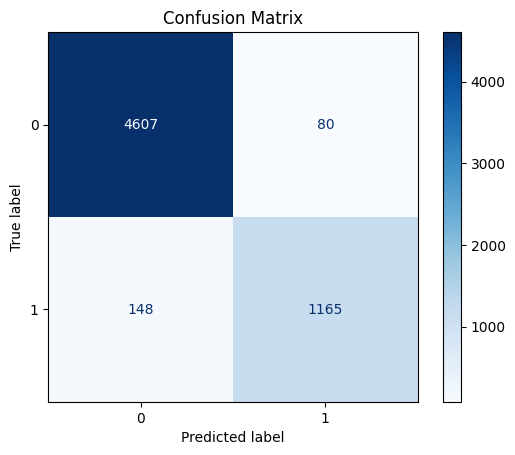

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = lr_model.predict(X_test) 
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:") 
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Confusion Matrix")
plt.grid(False) 
plt.show()

In [26]:
new_data = pd.DataFrame({
    'P_default': [0.25],
    'P_PAY_0_2': [0.10],
    'P_late_payment': [0.40],
    'PAY_0': [2],
    'BILL_AMT1': [3]  
})

In [27]:
new_data_scaled = scaler.transform(new_data)
new_pred_proba = lr_model.predict_proba(new_data_scaled)[:, 1]
print("Predicted probability of default for new data:", new_pred_proba[0])

Predicted probability of default for new data: 0.9999971527875162


**Using SMOTE**

In [28]:
from imblearn.over_sampling import SMOTE


features = ['P_default', 'P_PAY_0_2', 'P_late_payment', 'PAY_0', 'BILL_AMT1']
X = data[features].copy()
y = data['default.payment.next.month']

In [29]:
X = X.fillna(X.mean())
y = y.fillna(0)

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [33]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [34]:
print("Intercept:", lr_model.intercept_[0])
for feature, coef in zip(features, lr_model.coef_[0]):
    print(f"Coefficient for {feature}: {coef}")

Intercept: -5.173697759082772
Coefficient for P_default: 0.42865768966925516
Coefficient for P_PAY_0_2: -24.519563136520752
Coefficient for P_late_payment: 2.5126112432514045
Coefficient for PAY_0: 0.44436470964650404
Coefficient for BILL_AMT1: 21.82620729583825


In [35]:
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

print("Accuracy after SMOTE:", accuracy_score(y_test, y_pred))
print("ROC AUC after SMOTE:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report after SMOTE:")
print(classification_report(y_test, y_pred))

Accuracy after SMOTE: 0.9356944147228761
ROC AUC after SMOTE: 0.9920092405277539
Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4664
           1       0.94      0.93      0.94      4682

    accuracy                           0.94      9346
   macro avg       0.94      0.94      0.94      9346
weighted avg       0.94      0.94      0.94      9346



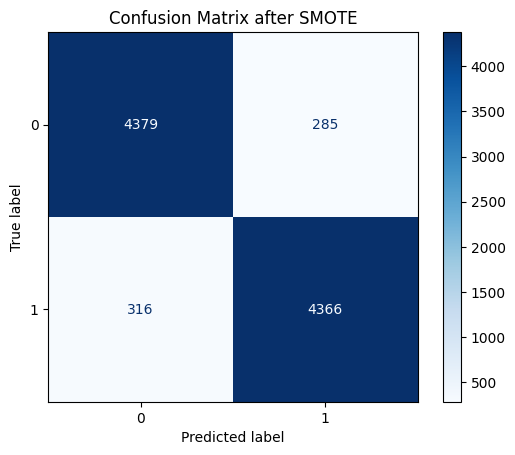

In [36]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix after SMOTE")
plt.grid(False)
plt.show()

In [37]:
new_data = pd.DataFrame({
    'P_default': [0.25],
    'P_PAY_0_2': [0.10],
    'P_late_payment': [0.40],
    'PAY_0': [2],
    'BILL_AMT1': [3]  
})
new_data_scaled = scaler.transform(new_data)
new_pred_proba = lr_model.predict_proba(new_data_scaled)[:, 1]
print("Predicted probability of default for new data:", new_pred_proba[0])

Predicted probability of default for new data: 0.9999691677657032
